# Shoe Classification

E-commerce has rapidly grown and their business strategies are completely based on user actions and user experiences. Although it is completely based on users, we should also not forget to say that there is a technology bridge in between users and growth in business. It may be Machine Learning or Deep Learning. Companies apply many image classification techniques on data to improve their catalog and give best suggestions to the users. They need accurate product classification on their platforms for better user experience. But when you talk about products, there exists a huge variety and classifying within varieties is really challenging. As a Deep Learning engineer, you should always try cracking these kinds of challenges by classifying things within a product itself.

*Data Description:* Data is all about images of shoes with multiple categories and data is collected from a popular Ecommerce site. Data set consists of two folders train and test.

## Importing Necessary Libraries

In [ ]:
!pip install tensorflow-gpu==2.0.0

In [64]:
pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 5.0 MB/s 


In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from imutils import paths
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import cv2
import os
from warnings import filterwarnings
from tqdm import tqdm_notebook as tqdm
import random
filterwarnings("ignore")

## Mounting google drive to retrieve the data later

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Specifying the directory

In [9]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Shoe Classification")

##Looking at at the image paths

In [12]:
imagepaths = sorted(list(paths.list_images("train")))
imagepaths[1]

'train/Boots/boots (10).jpg'

## Extracting the data from the specified directory

In [10]:
data  = []
labels = []
imagepaths = sorted(list(paths.list_images("train")))
with tqdm(total=len(imagepaths)) as pbar:
    for i in imagepaths:
        try:
            image = cv2.imread(i)
            image = cv2.resize(image, (28, 28))
        except:
            continue
        image = img_to_array(image)
        data.append(image)
        label = i.split(os.path.sep)[1]
        labels.append(label)
        pbar.update(1)

  0%|          | 0/778 [00:00<?, ?it/s]

## Label Encoding the labels and creating a dictory of the mapping

In [113]:
flabels = pd.Series(labels)
le = LabelEncoder()
le.fit(flabels)
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
label_mapping

{0: 'Boots', 1: 'Sandals', 2: 'Slippers'}

## Exploratory Data Analysis

In [15]:
flabels = le.transform(flabels)
flabels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Decreasing the resolution of the images to view them using matplotlib

In [16]:
flables = np.array(flabels)
data = np.array(data, dtype = "float")/255

## Analyzing the data distribution

In [17]:
f = pd.Series(flables)
f.value_counts()

0    326
1    306
2    146
dtype: int64

There's a slight imbalance in the dataset, Boots being highest in number and slippers being the lowest.

## Viewing the test path for data extraction

In [14]:
imagepaths = sorted(list(paths.list_images("test")))
imagepaths[1]

'test/image (10).jpg'

## Extracting the Test data

In [134]:
data_test  = []
imagepaths = sorted(list(paths.list_images("test")))
with tqdm(total=len(imagepaths)) as pbar:
    for i in imagepaths:
        try:
            image = cv2.imread(i)
            image = cv2.resize(image, (28, 28))
        except:
            continue
        image = img_to_array(image)
        data_test.append(image)
        pbar.update(1)

  0%|          | 0/89 [00:00<?, ?it/s]

In [117]:
labels[4]

'Boots'

##Plotting a fig for further analysis

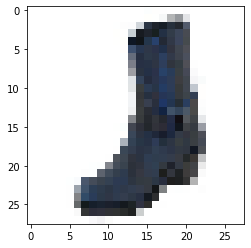

In [20]:
plt.imshow(data[100])
plt.show()

## Plotting some images along with their true value

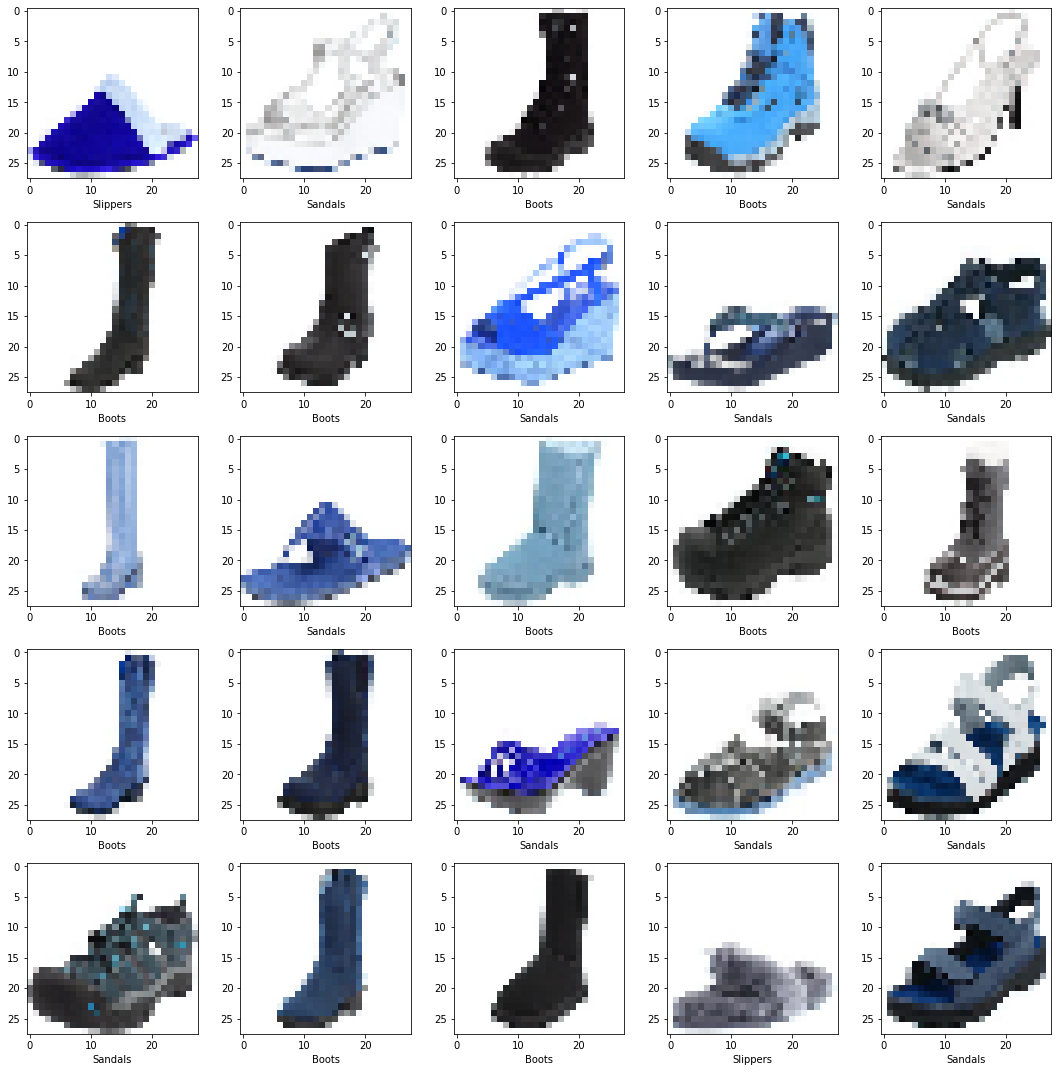

In [122]:
l_grid = 5
w_grid = 5
fig, ax = plt.subplots(l_grid, w_grid, figsize = (15,15))
for i,j in zip(np.arange(0, l_grid*w_grid), ax.flatten()):
    k= random.randint(0,700)
    j.imshow(data[k])
    j.set_xlabel(labels[k])
plt.tight_layout()
plt.show()

## Unique labels in the Dataset

In [58]:
f = pd.Series(flabels)
f.unique()

array([0, 1, 2])

## Builing the Model

In [88]:
def build_model(hp):  
  model = Sequential([
    Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,3)),

    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
         activation='relu'),

    Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
         kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'),
    
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Flatten(),
    
    Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),activation='relu', regularizers = "l1"),

    Dense(units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16), activation='relu', regularizers = "l1"),

    Dense(units=hp.Int('dense_3_units', min_value=32, max_value=128, step=16),activation='relu', regularizers = "l2"),

    Dense(len(f.unique()), activation='softmax')])
  
  model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

## Optimizing the model using Keras Tuner

In [89]:
tuner_search=RandomSearch(build_model,
                          objective='accuracy', max_trials= 10, directory='output',
                          project_name="Shoe_Classification")

INFO:tensorflow:Reloading Oracle from existing project output/Shoe_Classification/oracle.json
INFO:tensorflow:Reloading Tuner from output/Shoe_Classification/tuner0.json


In [90]:
tuner_search.search(data, flabels,epochs=50,validation_split=0.2)

Trial 10 Complete [00h 00m 12s]
accuracy: 1.0

Best accuracy So Far: 1.0
Total elapsed time: 00h 01m 12s
INFO:tensorflow:Oracle triggered exit


In [91]:
best_model=tuner_search.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 80)        6080      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 80)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          128064    
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 48)          76848     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 48)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 192)               0

##Splitting the train dataset into training set and validation set

In [45]:
x_train, x_val, y_train, y_val = train_test_split(data, flabels, random_state = 10, test_size = 0.1, stratify= flabels)

In [46]:
x_train.shape

(700, 28, 28, 3)

In [47]:
x_val.shape

(78, 28, 28, 3)

In [48]:
y_train.shape

(700,)

In [49]:
y_val.shape

(78,)

##Fitting the best model from the keras tuner search

In [92]:
Epochs = 50
M1 = best_model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs= Epochs)

Epoch 1/50
22/22 [==============================] - 1s 25ms/step - loss: 0.5667 - accuracy: 0.7971 - val_loss: 0.3129 - val_accuracy: 0.8590
Epoch 2/50
22/22 [==============================] - 0s 11ms/step - loss: 0.3041 - accuracy: 0.8843 - val_loss: 0.2460 - val_accuracy: 0.8846
Epoch 3/50
22/22 [==============================] - 0s 11ms/step - loss: 0.2528 - accuracy: 0.9057 - val_loss: 0.2535 - val_accuracy: 0.8846
Epoch 4/50
22/22 [==============================] - 0s 11ms/step - loss: 0.1975 - accuracy: 0.9371 - val_loss: 0.1992 - val_accuracy: 0.9103
Epoch 5/50
22/22 [==============================] - 0s 11ms/step - loss: 0.1551 - accuracy: 0.9443 - val_loss: 0.1852 - val_accuracy: 0.9359
Epoch 6/50
22/22 [==============================] - 0s 11ms/step - loss: 0.1549 - accuracy: 0.9400 - val_loss: 0.1852 - val_accuracy: 0.9359
Epoch 7/50
22/22 [==============================] - 0s 11ms/step - loss: 0.1076 - accuracy: 0.9643 - val_loss: 0.2656 - val_accuracy: 0.8974
Epoch 8/50
22

## Model Accuracy

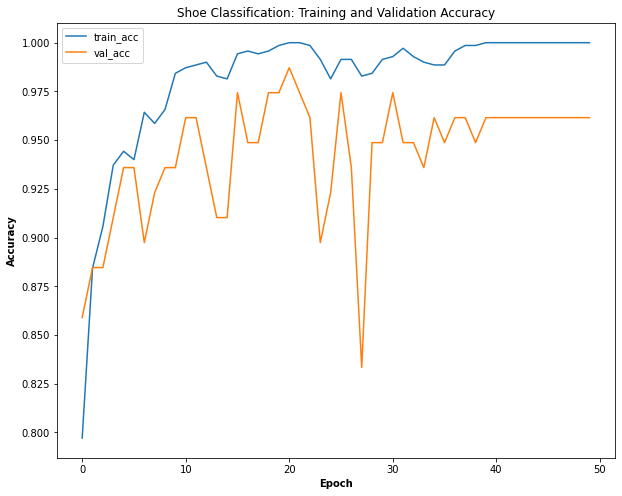

In [93]:
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, Epochs), M1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, Epochs), M1.history["val_accuracy"], label="val_acc")
plt.title("Shoe Classification: Training and Validation Accuracy")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

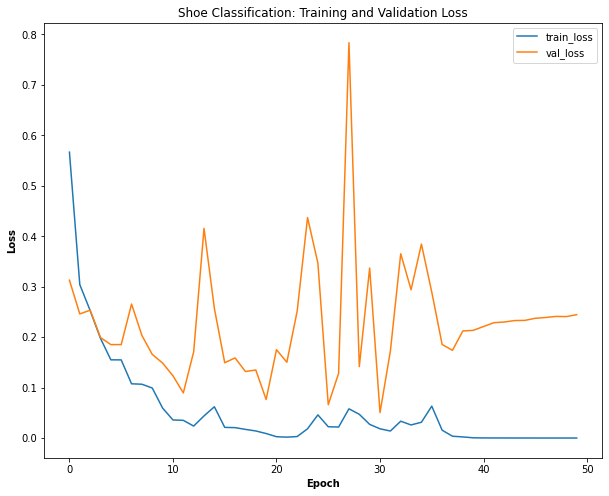

In [195]:
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, Epochs), M1.history["loss"], label="train_loss")
plt.plot(np.arange(0, Epochs), M1.history["val_loss"], label="val_loss")
plt.title("Shoe Classification: Training and Validation Loss")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

## Using image data generator for data augmentation

In [190]:
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         fill_mode="nearest")

## Fitting the augmented model

In [191]:
M2 = best_model.fit(x=aug.flow(x_train, y_train), validation_data=(x_val, y_val), epochs=Epochs)

Epoch 1/50
22/22 [==============================] - 1s 30ms/step - loss: 1.2947 - accuracy: 0.6014 - val_loss: 0.5682 - val_accuracy: 0.7308
Epoch 2/50
22/22 [==============================] - 1s 44ms/step - loss: 0.6638 - accuracy: 0.7129 - val_loss: 0.4287 - val_accuracy: 0.8077
Epoch 3/50
22/22 [==============================] - 1s 33ms/step - loss: 0.5949 - accuracy: 0.7357 - val_loss: 0.4404 - val_accuracy: 0.7949
Epoch 4/50
22/22 [==============================] - 1s 27ms/step - loss: 0.5328 - accuracy: 0.7614 - val_loss: 0.3274 - val_accuracy: 0.8846
Epoch 5/50
22/22 [==============================] - 1s 28ms/step - loss: 0.4760 - accuracy: 0.8100 - val_loss: 0.3898 - val_accuracy: 0.7949
Epoch 6/50
22/22 [==============================] - 1s 27ms/step - loss: 0.5190 - accuracy: 0.7586 - val_loss: 0.3193 - val_accuracy: 0.8590
Epoch 7/50
22/22 [==============================] - 1s 28ms/step - loss: 0.4034 - accuracy: 0.8400 - val_loss: 0.3520 - val_accuracy: 0.8205
Epoch 8/50
22

##Model Accuracy

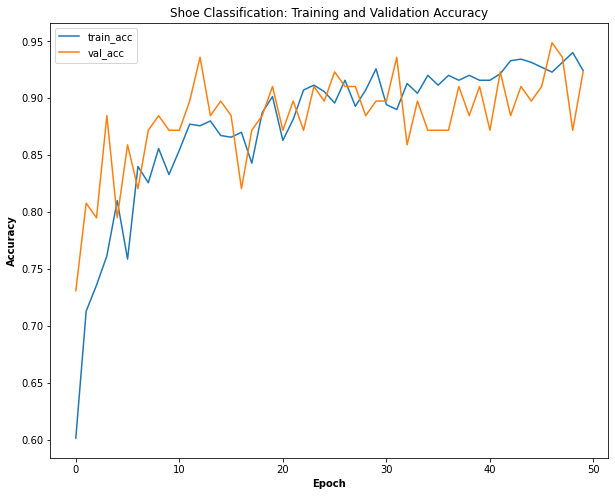

In [192]:
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, Epochs), M2.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, Epochs), M2.history["val_accuracy"], label="val_acc")
plt.title("Shoe Classification: Training and Validation Accuracy")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

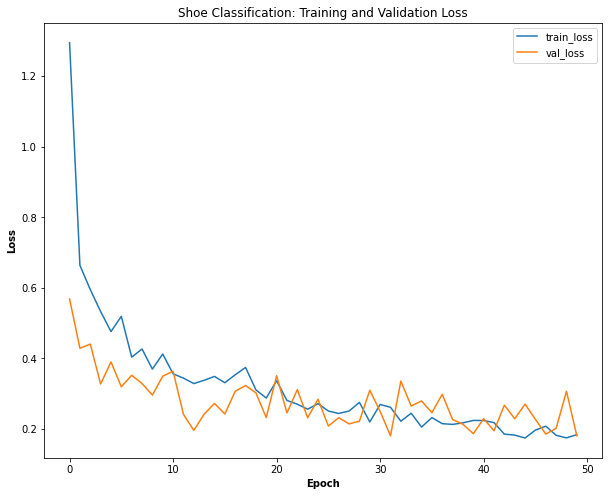

In [193]:
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, Epochs), M2.history["loss"], label="train_loss")
plt.plot(np.arange(0, Epochs), M2.history["val_loss"], label="val_loss")
plt.title("Shoe Classification: Training and Validation Loss")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

##Model Prediction

In [136]:
data_test = np.array(data_test, dtype = "float")/255

### Retrieving the class with highest probability

In [128]:
y_pred_prob = best_model.predict(data_test)
y_pred = []
for i in y_pred_prob:
    y_pred.append(np.argmax(i))

### Plotting test images along with their predictions

Predicted Classes==>


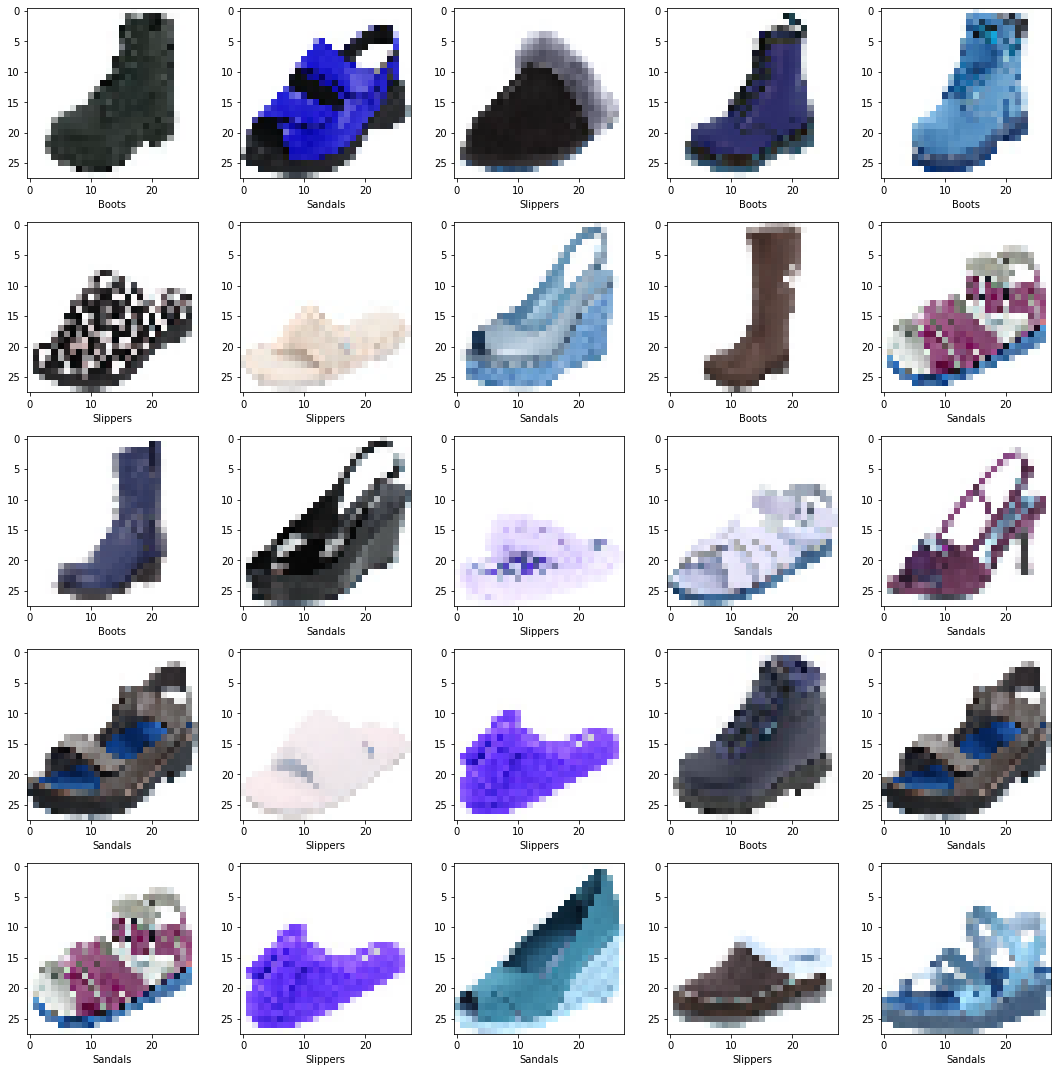

In [142]:
l_grid = 5
w_grid = 5
print("Predicted Classes==>")
fig, ax = plt.subplots(l_grid, w_grid, figsize = (15,15))
for i,j in zip(np.arange(0, l_grid*w_grid), ax.flatten()):
    k= random.randint(0,80)
    j.imshow(data_test[k])
    j.set_xlabel(label_mapping[y_pred[k]])
plt.tight_layout()
plt.show()

##Model Deployment

In [ ]:
!pip install gradio

In [188]:
import gradio as gr
def predict_image(image):
    data_pred  = []
    image = cv2.imread(imagepaths[2])
    image = cv2.resize(image, (28, 28))
    image = img_to_array(image)
    data_pred.append(image)
    d = np.array(data_pred, dtype = "float")/255
    preds = best_model.predict(d)
    final = np.argmax(preds)
    print(label_mapping[final])
    
    return label_mapping[final]

im = gr.inputs.Image(shape=(28,28))
label = gr.outputs.Label()

gr.Interface(fn=predict_image, inputs=im, outputs=label, capture_session=True, title="Shoe Classification").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://33276.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7efa7406a710>,
 'http://127.0.0.1:7862/',
 'https://33276.gradio.app')

Future Scope for optimization:
1. Can include dropout layers and callback.